In [27]:
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + ".,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD',s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusárski'))

#category lines dict
category_lines = {}
all_categories = []

def readLines(filename):
    lines = open(filename,encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Polish.txt', 'data/names/German.txt', 'data/names/Greek.txt', 'data/names/Czech.txt', 'data/names/French.txt', 'data/names/Japanese.txt', 'data/names/Scottish.txt', 'data/names/English.txt', 'data/names/Chinese.txt', 'data/names/Korean.txt', 'data/names/Dutch.txt', 'data/names/Spanish.txt', 'data/names/Vietnamese.txt', 'data/names/Portuguese.txt', 'data/names/Italian.txt', 'data/names/Russian.txt', 'data/names/Irish.txt', 'data/names/Arabic.txt']
Slusarski


In [28]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [29]:
import torch

def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1,n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def lineToTensor(line):
    tensor = torch.zeros(len(line),1,n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1 #faster than concatenation
    return tensor

In [30]:
import torch.nn as nn
import torch.nn.functional as F

#vanilla rnn
class RNN(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(RNN,self).__init__()

        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size,hidden_size)
        self.h2h = nn.Linear(hidden_size,hidden_size)
        self.h2o = nn.Linear(hidden_size,output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    def forward(self,input,hidden):
        hidden = F.tanh(self.i2h(input) + self.h2h(hidden))
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output,hidden
    def initHidden(self):
        return torch.zeros(1,self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters,n_hidden,n_categories)

In [31]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-3.0549, -2.7544, -2.8578, -2.7183, -2.8577, -2.9348, -2.8381, -2.7792,
         -2.9105, -3.0160, -2.9496, -3.0065, -2.8990, -2.8556, -2.9697, -2.9578,
         -2.8188, -2.9210]], grad_fn=<LogSoftmaxBackward0>)


In [32]:
def categoryFromOutput(output:torch.Tensor):
    _, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Czech', 3)


In [33]:
import random

def randomTrainingExample():
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)],dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category,line,category_tensor,line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print(f"category = {category} \\ line = {line}")

category = Greek \ line = Mersinias
category = Spanish \ line = Palomo
category = Czech \ line = Persein
category = Polish \ line = Slusarczyk
category = Polish \ line = Czajkowski
category = Portuguese \ line = Paredes
category = French \ line = Sargent
category = Korean \ line = Hong
category = Italian \ line = Ardizzone
category = Dutch \ line = Dalen


In [34]:
criterion = nn.NLLLoss() #apropriate for logSoftMax

In [35]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output,hidden = rnn(line_tensor[i],hidden)
    
    loss = criterion(output,category_tensor)
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data,alpha=-learning_rate)

    return output,loss.item()

In [36]:
import time
import math

n_itters = 200000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s/60)
    s -= m*60
    return f'{m}m {s}s'

start = time.time()
for iter in range(1, n_itters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output,loss = train(category_tensor,line_tensor)
    current_loss += loss

    if iter%print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = "T" if guess == category else f"F ({category})"
        print('%d %d%% (%s) %.4f %s / %s %s'%(iter,iter/n_itters*100,timeSince(start),loss,line,guess,correct))
    
    if iter%plot_every == 0:
        all_losses.append(current_loss/plot_every)
        current_loss = 0

5000 2% (0m 3.512871742248535s) 1.1880 Law / Chinese T
10000 5% (0m 7.002066612243652s) 0.8578 Thach / Vietnamese T
15000 7% (0m 10.464931964874268s) 1.0070 Ming / Chinese T
20000 10% (0m 13.9281907081604s) 2.1224 Ramaker / French F (Dutch)
25000 12% (0m 17.418189764022827s) 0.0953 Chrysanthopoulos / Greek T
30000 15% (0m 20.907275915145874s) 1.6971 Hepples / Dutch F (English)
35000 17% (0m 24.50815224647522s) 0.6464 Barros / Portuguese T
40000 20% (0m 27.98708486557007s) 1.7244 Hrula / Spanish F (Czech)
45000 22% (0m 31.4963436126709s) 0.9831 Schirmer / German T
50000 25% (0m 35.02594995498657s) 0.2095 Watson / Scottish T
55000 27% (0m 38.5591504573822s) 3.4353 Castillion / Irish F (Spanish)
60000 30% (0m 42.07258367538452s) 0.9856 Sutherland / Scottish T
65000 32% (0m 45.53329515457153s) 0.3497 Guerra / Spanish T
70000 35% (0m 49.01434350013733s) 0.0146 Hamamoto / Japanese T
75000 37% (0m 52.44739603996277s) 0.5965 Novak / Czech T
80000 40% (0m 55.899401903152466s) 0.0408 Pavlishin /

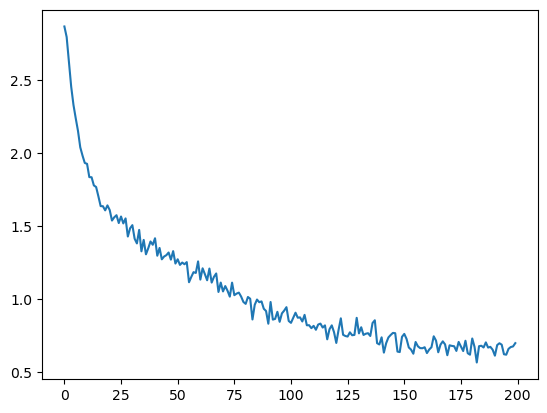

In [37]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

/tmp/ipykernel_109653/3585656379.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_109653/3585656379.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


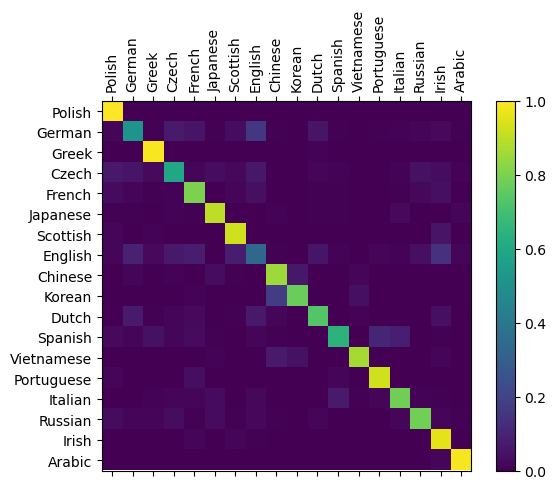

In [38]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()